In [61]:
# imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from time import time
import numpy as np
import matplotlib.pyplot as plt
import json, ROOT, os

# define constants
m_index = 0
pt_index = 1
pz_index = 2
num_attr = 3
EPOCHS = 600

In [62]:
# load config file
config = json.load(open("config/config_test_v1.json"))
events = json.load(open(config["FILES"]["events"]))
num_train = config["NUM"]["train"]
num_test = config["NUM"]["test"]
couplings = config["COUPLINGS"]
ckeys = couplings.keys()
kernel_l = config["MODEL_PARAM"]["kernel_l"]
nro = config["MODEL_PARAM"]["nro"]
a = config["MODEL_PARAM"]["a"]

In [63]:
# make sure the number of events you want don't exceed the total number of events
if num_train + num_test > len(events):
    print("the size of the training and test sets you input is greater than the number of data points available. please try again.")
    exit()

In [64]:
# define custom callback
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs = None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs = None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs = None):
        keys = list(logs.keys())
        if epoch % 100 == 0:
            print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs = None):
        keys = list(logs.keys())
        if epoch % 100 == 0:
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs = None):
        keys = list(logs.keys())
#         print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs = None):
        keys = list(logs.keys())
#         print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs = None):
        keys = list(logs.keys())
#         print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs = None):
        keys = list(logs.keys())
#         print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs = None):
        keys = list(logs.keys())
#         print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs = None):
        keys = list(logs.keys())
#         print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs = None):
        keys = list(logs.keys())
#         print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs = None):
        keys = list(logs.keys())
#         print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs = None):
        keys = list(logs.keys())
#         print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs = None):
        keys = list(logs.keys())
#         print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [65]:
def norm(x, m, sd):
    return (x - m) / sd

----------------------------------------------------------------------
coupling 1 of 1:
	input coupling of: M15K100
	output coupling of: M15K010
creating
	training dataset with 1000 events
	testing dataset with 1000 events
Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
End epoch 0 of training; got log keys: ['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']
Start epoch 100 of training; got log keys: []
End epoch 100 of training; got log keys: ['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']
Start epoch 200 of training; got log keys: []
End epoch 200 of training; got log keys: ['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']
Start epoch 300 of training; got log keys: []
End epoch 300 of training; got log keys: ['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']
Start epoch 400 of training; got log keys: []
End epoch 400 of training; got log keys: ['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']
Start epoch 500 of traini

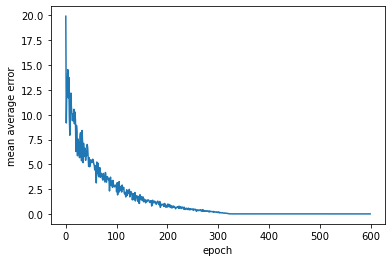

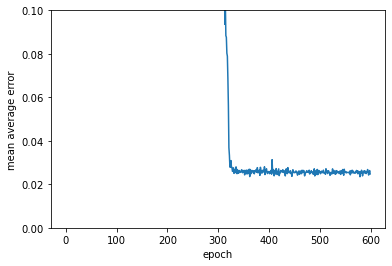

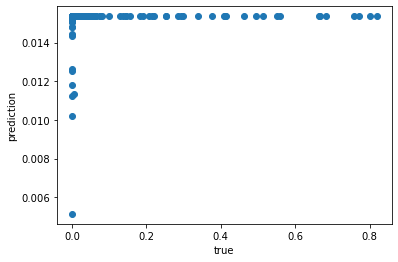

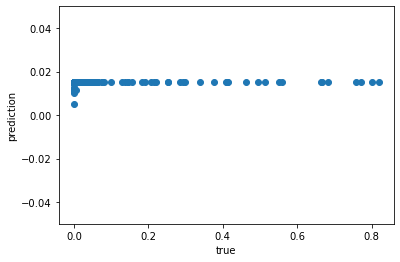

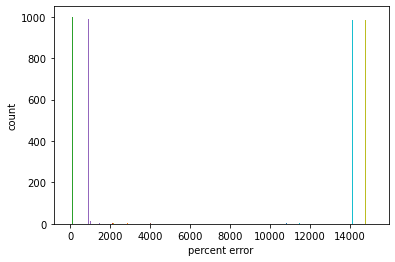

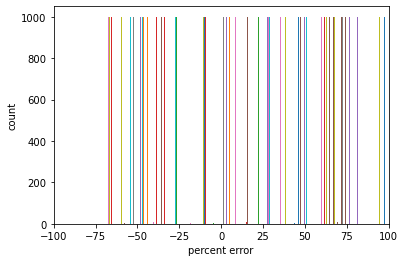

In [60]:
# neutal network training
counter = 0
for ckey in ckeys:
    print("----------------------------------------------------------------------")

    start = time()

    # define input and output coupling
    input_coupling = "M%2dK%03d" % (couplings[ckey]["Mi"], couplings[ckey]["Ki"])
    output_coupling = "M%2dK%03d" % (couplings[ckey]["Mf"], couplings[ckey]["Kf"])

    # define save directory
    save_dir = "/home/etsai11/data/plots/nn/" + input_coupling + "to" + output_coupling + "_ntr" + str(num_train) + "te" + str(num_test) + "_k" + str(kernel_l) + "_nro" + str(nro) + "_a" + str(a) + "/"

    # create save directory, unless it already exists
    if not os.path.isdir(save_dir):
        os.system("mkdir " + save_dir)

    # open runtime file
    f = open(save_dir + "runtimes.txt", "w")

    # print input and output couplings
    print("coupling " + ckey + " of " + str(len(ckeys)) + ":")
    print("\tinput coupling of: " + input_coupling)
    print("\toutput coupling of: " + output_coupling)

    f.write("coupling:\n")
    f.write("\tinput coupling of: " + input_coupling + "\n")
    f.write("\toutput coupling of: " + output_coupling + "\n")

    # creating training and testing datasets
    print("creating")
    print("\ttraining dataset with " + str(num_train) + " events")
    print("\ttesting dataset with " + str(num_test) + " events")

    f.write("creating\n")
    f.write("\ttraining dataset with " + str(num_train) + " events\n")
    f.write("\ttesting dataset with " + str(num_test) + " events\n")

    ev_num_train = []
    X_train = []
    y_train = []
    ev_num_test = []
    X_test = []
    y_test = []

    for i in range(num_train + num_test):
        e = events[str(i)]
        Top = e["2"]
        _4vector = ROOT.TLorentzVector()
        _4vector.SetPxPyPzE(Top["px"], Top["py"], Top["pz"], Top["e"])

        if i < num_train:
            ev_num_train.append(i)
            X_train.append([Top["m"], _4vector.Pt(), Top["pz"]])
            y_train.append(e["wts"][output_coupling] / e["wts"][input_coupling])
        else:
            ev_num_test.append(i)
            X_test.append([Top["m"], _4vector.Pt(), Top["pz"]])
            y_test.append(e["wts"][output_coupling] / e["wts"][input_coupling])

    # normalize data
#     X_train_m = sum(X_train) / len(X_train)
#     X_train_sd = (sum([((x - X_train_m) ** 2) for x in X_train]) / len(X_train)) ** 0.5
#     X_train_norm = norm(X_train, X_train_m, X_train_sd)

#     X_test_m = sum(X_test) / len(X_test)
#     X_test_sd = (sum([((x - X_test_m) ** 2) for x in X_test]) / len(X_test)) ** 0.5
#     X_test_norm = norm(X_test, X_test_m, X_test_sd)

    # convert to numpy arrays
    X_train = np.array(X_train)
#     X_train_norm = np.array(X_train_norm)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
#     X_test_norm = np.array(X_test_norm)
    y_test = np.array(y_test)

    # define model
    model = keras.Sequential([layers.Dense(64, activation = "relu", input_shape = [num_attr]), layers.Dense(64, activation = "relu"), layers.Dense(1)])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ["mae", "mse"])

    # model.summary()

    history = model.fit(X_train, y_train, epochs = EPOCHS, validation_split = 0.2, verbose = 0, callbacks = [CustomCallback()])
    # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    # history = model.fit(X_train_norm, y_train, epochs = EPOCHS, validation_split = 0.2, verbose = 0, callbacks = [early_stop, CustomCallback()])

    plt.figure(counter)
    counter += 1
    plt.plot(history.epoch, history.history["mae"])
    plt.xlabel("epoch")
    plt.ylabel("mean average error")

    # zoomed
    plt.figure(counter)
    counter += 1
    plt.plot(history.epoch, history.history["mae"])
    plt.ylim([0.0, 0.1])
    plt.xlabel("epoch")
    plt.ylabel("mean average error")
    
    loss, mae, mse = model.evaluate(X_test, y_test, verbose = 2)
    print("Testing set Mean Abs Error: {:5.2f}".format(mae))
    
    y_predict = model.predict(X_test)

    plt.figure(counter)
    counter += 1
    plt.scatter(y_test, y_predict)
    plt.xlabel("true")
    plt.ylabel("prediction")

    # zoomed
    plt.figure(counter)
    counter += 1
    plt.scatter(y_test, y_predict)
    plt.ylim([-0.05, 0.05])
    plt.xlabel("true")
    plt.ylabel("prediction")
    
    error = (y_predict - y_test) / y_test * 100

    plt.figure(counter)
    counter += 1
    plt.hist(error, bins = 50)
    plt.xlabel("percent error")
    plt.ylabel("count")

    # zoomed
    plt.figure(counter)
    counter += 1
    plt.hist(error, bins = 50)
    plt.xlim([-100.0, 100.0])
    plt.xlabel("percent error")
    plt.ylabel("count")

    print("runtime: " + str(time() - start))